In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
train = pd.read_csv('trainMB.csv')
test = pd.read_csv('testMB.csv')

In [3]:
train = train.rename(columns={'Unnamed: 0': 'date_forecast'})

In [4]:
train.set_index('date_forecast', inplace=True)
test.set_index('date_forecast', inplace=True)
train.index = pd.to_datetime(train.index)
train['is_est'] = 0
train['is_est'].iloc[-4418:] = 1


C:\Users\claxl\AppData\Local\Temp\ipykernel_57472\3272929725.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['is_est'].iloc[-4418:] = 1


In [5]:
import re
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [6]:
nan_col = ['snow_densitykgm3','ceiling_height_aglm','cloud_base_aglm']
for col in nan_col:
    
    test[col] = test[col].fillna(0)
    train[col] = train[col].fillna(train[col].median())

train=train.dropna()
test=test.dropna()

In [7]:
train.isna().sum()

absolute_humidity_2mgm3          0
air_density_2mkgm3               0
ceiling_height_aglm              0
clear_sky_energy_1hJ             0
clear_sky_radW                   0
cloud_base_aglm                  0
dew_or_rimeidx                   0
dew_point_2mK                    0
diffuse_radW                     0
diffuse_rad_1hJ                  0
direct_radW                      0
direct_rad_1hJ                   0
effective_cloud_coverp           0
elevationm                       0
fresh_snow_12hcm                 0
fresh_snow_1hcm                  0
fresh_snow_24hcm                 0
fresh_snow_3hcm                  0
fresh_snow_6hcm                  0
is_dayidx                        0
is_in_shadowidx                  0
msl_pressurehPa                  0
precip_5minmm                    0
precip_type_5minidx              0
pressure_100mhPa                 0
pressure_50mhPa                  0
prob_rimep                       0
rain_waterkgm2                   0
relative_humidity_10

In [8]:
train.columns

Index(['absolute_humidity_2mgm3', 'air_density_2mkgm3', 'ceiling_height_aglm',
       'clear_sky_energy_1hJ', 'clear_sky_radW', 'cloud_base_aglm',
       'dew_or_rimeidx', 'dew_point_2mK', 'diffuse_radW', 'diffuse_rad_1hJ',
       'direct_radW', 'direct_rad_1hJ', 'effective_cloud_coverp', 'elevationm',
       'fresh_snow_12hcm', 'fresh_snow_1hcm', 'fresh_snow_24hcm',
       'fresh_snow_3hcm', 'fresh_snow_6hcm', 'is_dayidx', 'is_in_shadowidx',
       'msl_pressurehPa', 'precip_5minmm', 'precip_type_5minidx',
       'pressure_100mhPa', 'pressure_50mhPa', 'prob_rimep', 'rain_waterkgm2',
       'relative_humidity_1000hPap', 'sfc_pressurehPa', 'snow_densitykgm3',
       'snow_depthcm', 'snow_driftidx', 'snow_melt_10minmm', 'snow_waterkgm2',
       'sun_azimuthd', 'sun_elevationd', 'super_cooled_liquid_waterkgm2',
       't_1000hPaK', 'total_cloud_coverp', 'visibilitym', 'wind_speed_10mms',
       'wind_speed_u_10mms', 'wind_speed_v_10mms', 'wind_speed_w_1000hPams',
       'minute', 'hour', 

In [9]:
train.shape, test.shape

((32819, 50), (720, 48))

In [10]:
import pandas as pd

# Esempio di un DataFrame con una colonna rappresentante una curva
data = {'Tempo': [1, 2, 3, 4, 5, 6, 7, 8],
        'Curva': [1, 2, 2, 2, 3, 3, 2, 2]}

df = train

# Sostituisci 'colonna_curva' con il nome della colonna che rappresenta la curva
nome_colonna_curva = 'pv_measurement'

# Calcola la differenza tra i valori adiacenti
df['Differenza'] = df[nome_colonna_curva].diff()

# Filtra le righe in cui la differenza è diversa da zero
df_senza_stazionari = df[df['Differenza'] != 0]

# Ora df_senza_stazionari conterrà solo le righe in cui la curva non è stazionaria
# Puoi rimuovere la colonna 'Differenza' se non è più necessaria
df_senza_stazionari = df_senza_stazionari.drop(columns=['Differenza'])

df_senza_stazionari['pv_measurement'] = df_senza_stazionari['pv_measurement'].dropna()
df_senza_stazionari

,absolute_humidity_2mgm3,air_density_2mkgm3,ceiling_height_aglm,clear_sky_energy_1hJ,clear_sky_radW,cloud_base_aglm,dew_or_rimeidx,dew_point_2mK,diffuse_radW,diffuse_rad_1hJ,...,visibilitym,wind_speed_10mms,wind_speed_u_10mms,wind_speed_v_10mms,wind_speed_w_1000hPams,minute,hour,month,pv_measurement,is_est
date_forecast,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,5.55,1.2395,1200.700012,0.000000e+00,0.000000,1200.700012,0.0,275.150009,0.000000,0.000000,...,16823.399902,2.80,1.20,2.55,-0.0,22.5,0.0,1.0,0.000000,0
2019-01-01 10:00:00,5.70,1.2505,1856.150024,4.517990e+04,20.650000,1856.150024,0.0,275.600006,3.400000,7203.199707,...,3877.450073,7.30,5.50,-4.80,0.0,22.5,10.0,1.0,0.862500,0
2019-01-01 11:00:00,5.60,1.2540,2179.200073,9.082660e+04,27.100000,2179.200073,0.0,275.349991,5.350000,15655.649902,...,13198.600098,7.00,5.40,-4.45,0.0,22.5,11.0,1.0,10.350000,0
2019-01-01 12:00:00,5.45,1.2570,2424.950073,8.985360e+04,20.150000,2424.950073,0.0,274.899994,7.350000,22645.500000,...,20815.500000,6.60,5.20,-4.10,0.0,22.5,12.0,1.0,5.175000,0
2019-01-01 13:00:00,5.30,1.2625,2554.449951,4.286300e+04,2.450000,2554.449951,0.0,274.500000,0.950000,15217.299805,...,11989.649902,7.30,4.85,-5.50,0.0,22.5,13.0,1.0,0.862500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30 16:00:00,4.50,1.2695,2185.000000,1.266570e+06,285.699997,656.700012,0.0,272.349991,122.650002,503916.500000,...,22730.750000,7.00,7.00,0.55,-0.0,22.5,16.0,4.0,197.669857,1
2023-04-30 17:00:00,4.60,1.2720,2007.900024,7.911844e+05,155.599998,581.699982,0.0,272.500000,73.450001,352996.000000,...,20819.199219,6.30,6.20,1.15,-0.0,22.5,17.0,4.0,118.454331,1
2023-04-30 18:00:00,4.60,1.2745,1950.000000,3.587465e+05,50.850000,544.299988,0.0,272.500000,27.650000,181940.500000,...,22582.700195,5.75,5.45,1.75,-0.0,22.5,18.0,4.0,45.263035,1


In [11]:
df_senza_stazionari['pv_measurement'].dropna()
df_senza_stazionari = df_senza_stazionari.reset_index()

<Axes: >

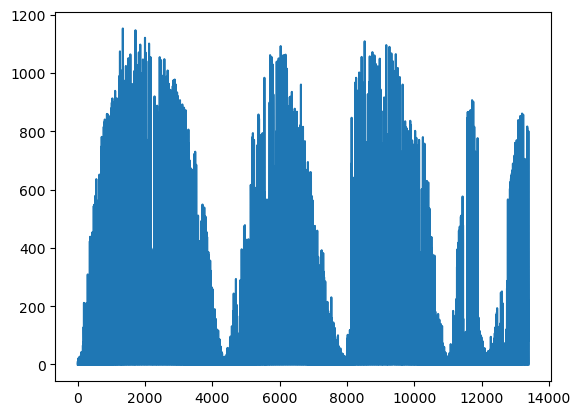

In [12]:
df_senza_stazionari['pv_measurement'].plot()

In [13]:
df_senza_stazionari = df_senza_stazionari.reset_index()

In [14]:
train = df_senza_stazionari

In [15]:
train['pv_measurement'] = train['pv_measurement'].mask(train['is_in_shadowidx'] == 1, 0)


<Axes: >

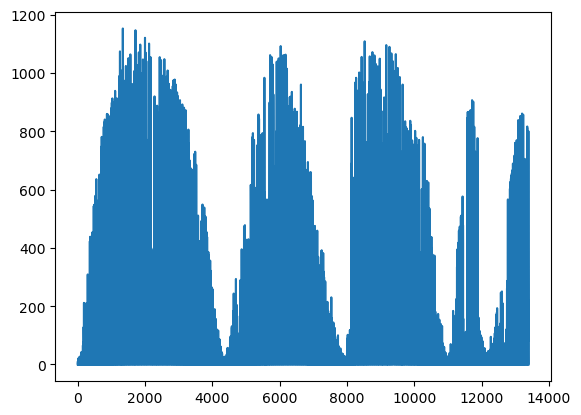

In [16]:
train['pv_measurement'].plot()

In [17]:
train.set_index('date_forecast', inplace=True)
train.index = pd.to_datetime(train.index)

In [18]:
train  = train.drop(columns = 'index')

In [19]:
def transform(df):
    for col in df.columns:
        if col == 'pv_measurement':
            df['pv_measurement'] = np.sqrt(df['pv_measurement'])
            continue
        new_col_name = col + "_sqrt"
        df[new_col_name] = np.sqrt(df[col])

    return df

In [20]:
train = transform(train)
test = transform(test)

C:\Users\claxl\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\claxl\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\claxl\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\claxl\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\claxl\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\claxl\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sq

In [21]:
train.shape,test.shape

((13401, 99), (720, 96))

In [26]:
test.isna().mean()

absolute_humidity_2mgm3        0.000000
air_density_2mkgm3             0.000000
ceiling_height_aglm            0.000000
clear_sky_energy_1hJ           0.000000
clear_sky_radW                 0.000000
                                 ...   
wind_speed_v_10mms_sqrt        0.572222
wind_speed_w_1000hPams_sqrt    0.000000
minute_sqrt                    0.000000
hour_sqrt                      0.000000
month_sqrt                     0.000000
Length: 96, dtype: float64

In [27]:
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

In [28]:
train['hours'] = train.index.hour
train['day'] = train.index.day
train['month'] = train.index.month
train['year'] = train.index.year
train['dayofyear'] = train.index.dayofyear

In [29]:
test['hours'] = test.index.hour
test['day'] = test.index.day
test['month'] = test.index.month
test['year'] = test.index.year
test['dayofyear'] = test.index.dayofyear

In [30]:
train = train.fillna(0)
test = test.fillna(0)

In [31]:
# Supponiamo che "gruppi" sia il risultato della suddivisione
gruppi = train.groupby('is_est')

# Itera attraverso i gruppi e crea un DataFrame separato per ciascun gruppo
dataframes_per_gruppo = {}
for valore, gruppo in gruppi:
    dataframes_per_gruppo[valore] = gruppo.copy()
train_set = dataframes_per_gruppo[0]
val_set = dataframes_per_gruppo[1]

In [33]:
train = train.drop(columns = ['is_est','is_est_sqrt'])

In [32]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt', None]
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]


In [34]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
                'n_jobs' : [-1]
             }
print(param_grid)

{'n_estimators': [10, 42, 74, 106, 138, 171, 203, 235, 267, 300], 'max_features': ['log2', 'sqrt', None], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False], 'n_jobs': [-1]}


In [35]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
rf_Model = RandomForestRegressor()

y_train = train['pv_measurement']
X_train = train.drop(columns = 'pv_measurement')
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = param_grid, cv = 10, verbose=2, n_jobs = 4)
rf_RandomGrid.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4],
                                        'max_features': ['log2', 'sqrt', None],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [10, 42, 74, 106, 138,
                                                         171, 203, 235, 267,
                                                         300],
                                        'n_jobs': [-1]},
                   verbose=2)

In [44]:
model_A = RandomForestRegressor(**rf_RandomGrid.best_params_)

In [45]:
X_train = train.drop(columns = 'pv_measurement' )
y_train = train['pv_measurement']

In [ ]:
model_A.fit(X_train,y_train)

In [47]:
y_pred_A = model_A.predict(test.drop(columns = 'date_forecast'))

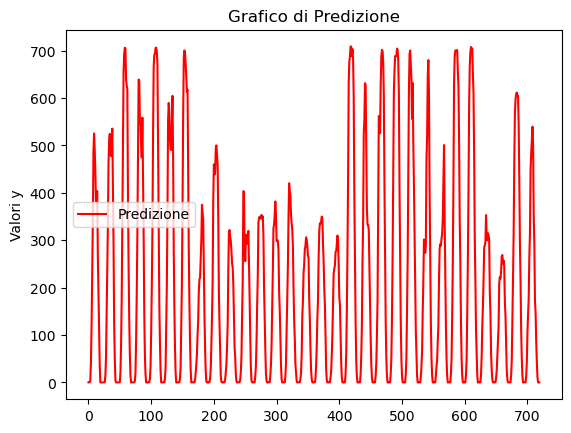

In [48]:
plt.plot(range(len(y_pred_A)), (y_pred_A)**2, label='Predizione', color='red', linestyle='-')
# Aggiungi una legenda
plt.legend()

# Aggiungi etichette agli assi
plt.ylabel('Valori y')

# Titolo del grafico
plt.title('Grafico di Predizione')

# Mostra il grafico
plt.show()

In [49]:
df = pd.DataFrame({'Prediction':y_pred_A**2})

In [50]:
test = test.reset_index()
df.loc[test['is_in_shadowidx'] == 1, 'Prediction'] = 0


In [51]:
df.to_csv('B1.csv')

In [52]:
df

,Prediction
0,0.000000
1,0.000000
2,0.000000
3,5.425849
4,43.749651
...,...
715,42.243420
716,11.064311
717,0.000000
718,0.000000
